In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pixelcnn import Trainer

In [3]:
trainer = Trainer()
trainer.num_epochs = 128
trainer.setup()
trainer.train()

KeyboardInterrupt: 

In [ ]:
batch = trainer.val_ds[0].unsqueeze(0)
batch = batch.to(trainer.device)
pred = trainer.model.predict(batch, (16, 16))[0]

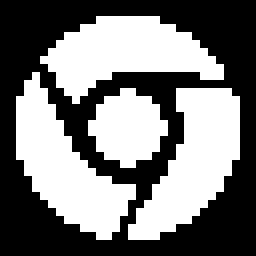

In [ ]:
import torchvision.transforms.functional as F
image = trainer.val_ds[3]
F.to_pil_image(image).resize((256, 256), 0)

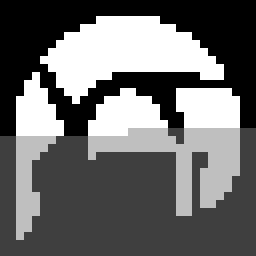

In [ ]:
import numpy as np
batch = image.unsqueeze(0).to(trainer.device)
pred = trainer.model.predict(batch, (16, 16))[0]
for iy, ix, ic in np.ndindex((32, 32, 1)):
    if (iy, ix) >= (16, 16):
        pred[ic,iy,ix] = 0.25 + 0.5 * pred[ic,iy,ix]
F.to_pil_image(pred).resize((256, 256), 0)